In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, Model
from math import ceil
from keras.layers import Input, Dense, Dropout, Activation, Flatten, ReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook



In [2]:
def get_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    X_train = 2*(X_train/255)-1
    X_test = 2*(X_train/255)-1

    return X_train, X_test

In [3]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose
from keras.initializers import RandomNormal
from tensorflow.keras.layers import Activation, Reshape, BatchNormalization
from tensorflow.keras.layers import LeakyReLU


In [4]:
def Build_generator (dim_z = 128, n_filter = 64):
   init = RandomNormal(stddev=0.02)
   g= Sequential()
   dense_layer  = Dense(2*2*n_filter*8, input_shape=(dim_z,), use_bias=True, kernel_initializer=init)
   g.add(dense_layer)

   g.add(Reshape((2,2,n_filter*8)))
   g.add(BatchNormalization())
   g.add(LeakyReLU(0.2))

   g.add(Conv2DTranspose(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   g.add(BatchNormalization())
   g.add(LeakyReLU(0.2))

   g.add(Conv2DTranspose(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   g.add(BatchNormalization())
   g.add(LeakyReLU(0.2))

   g.add(Conv2DTranspose(n_filter, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   g.add(BatchNormalization())
   g.add(LeakyReLU(0.2))

   g.add(Conv2DTranspose(3, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   g.add(BatchNormalization())
   g.add(Activation('tanh'))

   print(g.summary())
   return g

In [5]:
def Build_Discriminator (input_shape=(32,32,3), n_filter=64):
   init = RandomNormal(stddev=0.02)
   d = Sequential()
   d.add(Conv2D(n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   d.add(LeakyReLU(0.2))

   d.add(Conv2D(2*n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   d.add(BatchNormalization())
   d.add(LeakyReLU(0.2))

   d.add(Conv2D(4*n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   d.add(BatchNormalization())
   d.add(LeakyReLU(0.2))

   d.add(Conv2D(8*n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
   d.add(BatchNormalization())
   d.add(LeakyReLU(0.2))

   d.add(Flatten())
   d.add(Dense(1, kernel_initializer=init))
   d.add(Activation('sigmoid'))

   print(d.summary())
   return d


In [6]:
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images + 1) / 2. * 255.
    images = images.astype(np.uint8)
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    #plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    plt.imshow(images)
    plt.show()

def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)

In [7]:
def train(n_filter=64, z_dim=100, lr_d=2e-4, lr_g=2e-4, epochs=300, batch_size=128,
          epoch_per_checkpoint=1, n_checkpoint_images=36, verbose=10):
    X_train,_ = get_data()
    image_shape = X_train[0].shape
    print('Image shape {}, min val {}, max val {}'.format(image_shape, np.min(X_train[0]), np.max(X_train[0])))

    plot_images(X_train[:n_checkpoint_images], 'real_image.png')

    # Build model
    G = Build_generator (z_dim, n_filter)
    D = Build_Discriminator(image_shape, n_filter)

    # Loss for discriminator
    D.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # D(G(X))
    D.trainable = False
    z = Input(shape=(z_dim,))
    D_of_G = Model(inputs=z, outputs=D(G(z)))

    # Loss for generator
    D_of_G.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Labels for computing the losses
    real_labels = np.ones(shape=(batch_size, 1))
    fake_labels = np.zeros(shape=(batch_size, 1))
    losses_d, losses_g = [], []

    # fix a z vector for training evaluation
    z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))

    for e in tqdm_notebook(range(1, epochs+1)):
        n_steps = X_train.shape[0]//batch_size
        for i in range(n_steps):
            # Train discriminator
            D.trainable = True
            real_images = X_train[i*batch_size:(i+1)*batch_size]
            loss_d_real = D.train_on_batch(x=real_images, y=real_labels)[0]

            z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            fake_images = G.predict_on_batch(z)
            loss_d_fake = D.train_on_batch(x=fake_images, y=fake_labels)[0]

            loss_d = loss_d_real + loss_d_fake
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=real_labels)[0]

            losses_d.append(loss_d)
            losses_g.append(loss_g)


            if i == 0 and e%verbose == 0:
                print('Epoch {}'.format(e))
                fake_images = G.predict(z_fixed)
                #print("\tPlotting images and losses")
                plot_images(fake_images, "Images1/fake_images_e_{}.png".format(e))
                #plot_losses(losses_d, losses_g, "losses.png")

Image shape (32, 32, 3), min val -1.0, max val 1.0


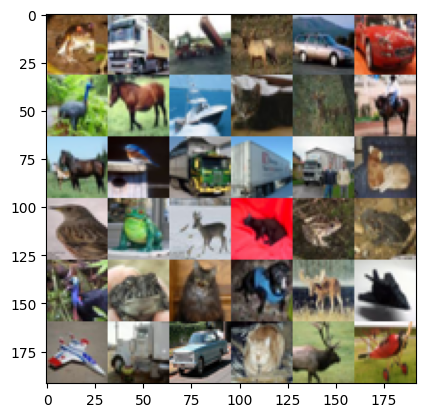

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 batch_normalization (Batch  (None, 2, 2, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         3277056   
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 4, 4, 256)         1

None


<ipython-input-7-37c8a5cbbfdc>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epochs+1)):


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
train()